In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
n_examples = 5000
model = "Standard"
attack = "UPGD"
norm = "Linf"
epsilon = "255_8"
iterations = 2
restarts = 1
alpha = "0_01"
rand_init = True



attack_dir = f"results/cifar10/n_examples_{n_examples}/model_{model}/attack_{attack}/norm_{norm}_eps_from_{epsilon}_iter_{iterations}_restarts_{restarts}_alpha_{alpha}_rand_init_{rand_init}"

In [3]:
# load perturbations from perturbations directory under attack_dir
perturbations_dir = os.path.join(attack_dir, "perturbations")
# under one file named adv_input.pt
perturbations = torch.load(os.path.join(perturbations_dir, "adv_input.pt"))
universal_perturbation = torch.load(os.path.join(perturbations_dir, "universal_pert.pt"))

/tmp/ipykernel_1391388/3373895012.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  perturbations = torch.load(os.path.join(perturbations_dir, "adv_input.pt"))
/tmp/ipyker

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1372607..3.1372607].


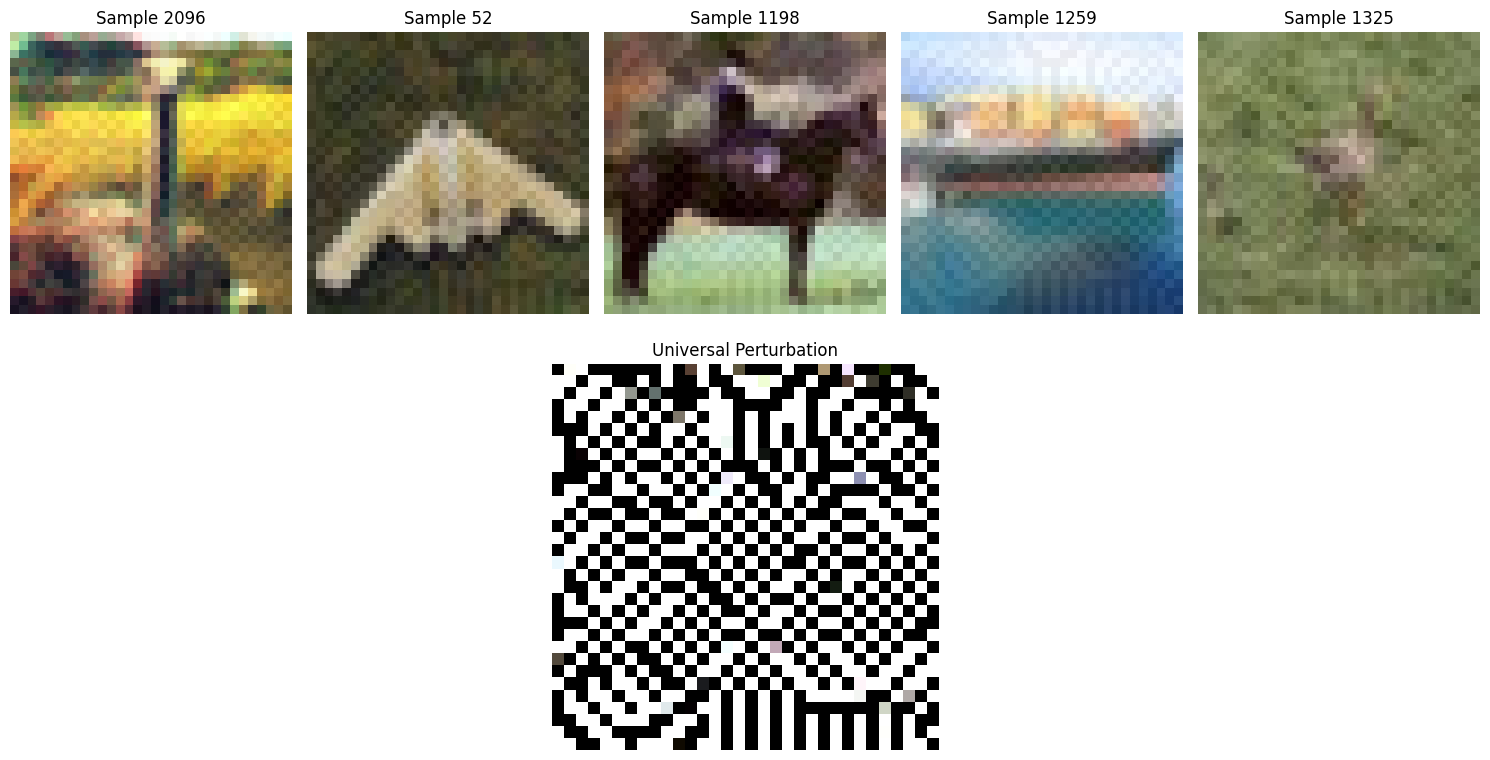

In [8]:
# sample and present some perturbations (perturbations.shape = torch.Size([500, 3, 32, 32]))
# and the universal perturbation (universal_perturbation.shape = torch.Size([3, 32, 32]))
n_samples = 5
sample_indices = np.random.choice(n_examples, n_samples, replace=False)
fig = plt.figure(figsize=(15, 8))

# Create the subplots for sampled images (first row)
for i, idx in enumerate(sample_indices):
    ax = fig.add_subplot(2, n_samples, i + 1)
    ax.imshow(perturbations[idx].cpu().permute(1, 2, 0).numpy())
    ax.axis("off")
    ax.set_title(f"Sample {idx}")

# Create a single subplot for the universal perturbation (second row, spanning all columns)
ax_universal = fig.add_subplot(2, 1, 2)
ax_universal.imshow(universal_perturbation.cpu().permute(1, 2, 0).numpy()*100)
ax_universal.axis("off")
ax_universal.set_title("Universal Perturbation")

# Adjust the layout for clarity
plt.tight_layout()
plt.show()

In [5]:
universal_perturbation

tensor([[[-0.0299,  0.0112,  0.0181,  ..., -0.0314,  0.0151,  0.0250],
         [ 0.0314,  0.0176, -0.0214,  ..., -0.0062, -0.0314,  0.0235],
         [ 0.0314, -0.0314,  0.0296,  ...,  0.0019,  0.0255, -0.0214],
         ...,
         [-0.0101, -0.0314,  0.0205,  ...,  0.0314, -0.0314, -0.0314],
         [ 0.0314, -0.0310, -0.0314,  ...,  0.0166, -0.0314,  0.0314],
         [ 0.0178,  0.0274, -0.0314,  ...,  0.0265,  0.0314, -0.0214]],

        [[-0.0294,  0.0102,  0.0178,  ..., -0.0314,  0.0150,  0.0245],
         [ 0.0314,  0.0170, -0.0214,  ..., -0.0070, -0.0314,  0.0235],
         [ 0.0314, -0.0304,  0.0288,  ...,  0.0018,  0.0245, -0.0214],
         ...,
         [-0.0111, -0.0314,  0.0206,  ...,  0.0314, -0.0314, -0.0314],
         [ 0.0314, -0.0311, -0.0314,  ...,  0.0164, -0.0314,  0.0314],
         [ 0.0174,  0.0268, -0.0314,  ...,  0.0264,  0.0314, -0.0214]],

        [[-0.0284,  0.0098,  0.0176,  ..., -0.0289,  0.0148,  0.0250],
         [ 0.0284,  0.0160, -0.0185,  ..., -0